## Example of our best model's usage

In [1]:
# MUST be the first cell in the notebook
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from utils import train_model, evaluate_model
import torch.optim as optim
import sys
from utils import load_it_data, visualize_img, compute_ev_and_corr
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [2]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [3]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [4]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        return (img, neural_activity) if neural_activity is not None else img


# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
def evaluate_model(model, dataloader, spikes_val, device='cpu'):
    """
    Evaluate the model using explained variance and correlation.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        spikes_val (numpy array): Ground truth neural activity for validation.
        loss_function (nn.Module, optional): Loss function (if needed for logging).
        device (str): Device to evaluate on ('cpu' or 'cuda').

    Returns:
        None
    """
    model.to(device)
    model.eval()

    # Compute explained variance & correlation
    overall_ev, overall_corr, ev_per_neuron, corr_per_neuron = compute_ev_and_corr(model, dataloader, spikes_val)

    print(f'Overall explained variance: {overall_ev:.4f}')
    print(f'Overall correlation: {overall_corr:.4f}')

    # Plot histograms for explained variance & correlation
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].hist(ev_per_neuron, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title('Explained Variance per Neuron')
    axs[0].set_xlabel('Explained Variance')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(corr_per_neuron, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title('Correlation per Neuron')
    axs[1].set_xlabel('Correlation Coefficient')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [6]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model = backbone.cpu()
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
model.load_state_dict(torch.load('./models/DenseNet201.pth'))


Model parameters: 18,415,656


<All keys matched successfully>

In [7]:
device = 'cpu'

Overall explained variance: 0.4937
Overall correlation: 0.6971


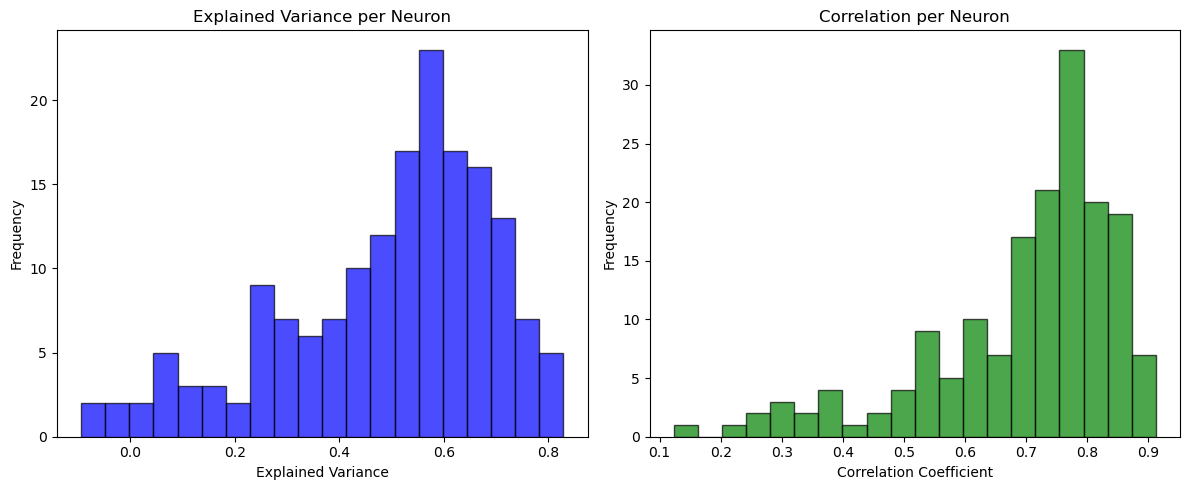

In [8]:
# Evaluate model on the validation set
evaluate_model(model, val_dataloader, spikes_val, device="cpu")